## Diffusion rate 

Now we want to have a look at what happens to the energy production when we change the diffusion rate of LED.
It was necessary to create an entirely new notebook as it was not possible to import the previous exercise as scenario, becaue it was marked as "locked" (although the connection was closed already). So let's restart everything again from the beginning shall we?

These first steps are exactly the same as in the first notebook. So we can skip a bit, see you at the next comment.

In [339]:
import pandas as pd
import ixmp
import message_ix

from message_ix.utils import make_df

%matplotlib inline

In [340]:
mp = ixmp.Platform()

INFO:ixmp.backend.jdbc:launching ixmp.Platform connected to jdbc:hsqldb:file:C:/Users/casamassima/.local/share/ixmp/localdb/default


Firsst of all we need to import the base scenario, clone it and call it scen.

In [341]:
model = 'Westeros Electrified'

base = message_ix.Scenario(mp, model=model, scenario='baseline')
scen = base.clone(model, 'led_introduction','introducing LED technology in Westeros',
                  keep_solution=False)
scen.check_out()

We define the previous year and the year of the actual analysis.

In [342]:
year_df = scen.vintage_and_active_years()
vintage_years, act_years = year_df['year_vtg'], year_df['year_act']
model_horizon = scen.set('year')
country = 'Westeros'

In [343]:
base = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'mode': 'standard',
    'time': 'year',
    'unit': '-',
}

base_input = make_df(base, node_origin=country, time_origin='year')
base_output = make_df(base, node_dest=country, time_dest='year')

In [344]:
scen.add_set("technology", ['LED'])

In [345]:
LED_out = make_df(base_output, technology='LED', commodity='light', 
                   level='useful', value=1.0)
scen.add_par('output', LED_out)

LED_in = make_df(base_input, technology='LED', commodity='electricity',  
                  level='final', value=1.0)
scen.add_par('input', LED_in)

In [346]:
base_capacity_factor = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'time': 'year',
    'unit': '-',
}

In [347]:
capacity_factor = {
    'coal_ppl': 1,
    'wind_ppl': 0.36,
    'bulb': 1, 
    'LED' : 1,
}

for tec, val in capacity_factor.items():
    df = make_df(base_capacity_factor, technology=tec, value=val)
    scen.add_par('capacity_factor', df)

In [348]:
base_technical_lifetime = {
    'node_loc': country,
    'year_vtg': model_horizon,
    'unit': 'y',
}

In [349]:
lifetime = {
    'coal_ppl': 20,
    'wind_ppl': 20,
    'bulb': 1,
    'LED' : 4, #LED lifetime in hours goes from 35000 to 50000. 35000/8760 = 3.99 years. Engineers say it's 4 years.
}

for tec, val in lifetime.items():    
    df = make_df(base_technical_lifetime, technology=tec, value=val)
    scen.add_par('technical_lifetime', df)

In [350]:
history = [690]
demand_per_year = 40 * 12 * 1000 / 8760

grid_efficiency = 0.9
historic_demand = 0.85 * demand_per_year
historic_generation = historic_demand / grid_efficiency
LED_fraction = 0.1 # 10% are LEDs
coal_fraction = 0.6

base_capacity = {
    'node_loc': country,
    'year_vtg': history,
    'unit': 'GWa',
}

base_activity = {
    'node_loc': country,
    'year_act': history,
    'mode': 'standard',
    'time': 'year',
    'unit': 'GWa',
}


old_activity = {
    'coal_ppl': coal_fraction * historic_generation,
    'wind_ppl': (1 - coal_fraction) * historic_generation,
    'LED' : LED_fraction * historic_demand,
    'bulb' : (1-LED_fraction) * historic_demand
}

for tec, val in old_activity.items():
    df = make_df(base_activity, technology=tec, value=val)
    scen.add_par('historical_activity', df)
    
    
act_to_cap = {
    'coal_ppl': 1 / 10 / capacity_factor['coal_ppl'] / 2, # 20 year lifetime
    'wind_ppl': 1 / 10 / capacity_factor['wind_ppl'] / 2,
    'LED': 1 / 10 / capacity_factor['LED'] / 0.4, # 4 years lifetime
    'bulb': 1 / 10 / capacity_factor['bulb'] / 0.1, #1 year lifetime
}

for tec in act_to_cap:
    value = old_activity[tec] * act_to_cap[tec]
    df = make_df(base_capacity, technology=tec, value=value)
    scen.add_par('historical_new_capacity', df)


In [351]:
scen.add_par("interestrate", model_horizon, value=0.05, unit='-')

In [352]:
base_inv_cost = {
    'node_loc': country,
    'year_vtg': model_horizon,
    'unit': 'USD/kW',
}

# Adding a new unit to the library
mp.add_unit('USD/kW')     

INFO:root:unit `USD/kW` is already defined in the platform instance


In [353]:
# in $ / kW (specific investment cost)
costs = {
    'coal_ppl': 500,
    'wind_ppl': 1500,
    'bulb': 5,
    'LED' : 266, #15W LED lamp costs 4€. 4€/0.015kW = 266 1€ almost = 1$. 
}

for tec, val in costs.items():
    df = make_df(base_inv_cost, technology=tec, value=val)
    scen.add_par('inv_cost', df)

## Changing the diffusion rate
Finally something new.
Now we can change the diffusion rate of the LEDs. Because we are applying science, we want to change one parameter at the time to analyse how the results are affected. For this reason it was necessary to not include taxation in this simulation and start anew. <br>
To check what happens to the energy production when we change the diffusion rate change the value as indicated in the commented section of the code below.

In [354]:
#DIFFUSION RATE
base_growth = {
    'node_loc': country,
    'year_act': model_horizon,
    'time': 'year',
    'unit': '-',
}

growth_technologies = [
    "LED"
]

for tec in growth_technologies:
    df = make_df(base_growth, technology=tec, value=1)    #change the value from 1 to 0.01 to see different effects.
    scen.add_par('growth_activity_up', df)


## Changing the efficiency of bulbs 
Again it is needed to change the efficiency of bulbs to 85%. More explanation in the first notebook. 

In [355]:
base = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'mode': 'standard',
    'time': 'year',
    'unit': '-',
}

base_input = make_df(base, node_origin=country, time_origin='year')
base_output = make_df(base, node_dest=country, time_dest='year')


bulb_out = make_df(base_output, technology='bulb', commodity='light', 
                   level='useful', value=0.85)
scen.add_par('output', bulb_out)
LED_out = make_df(base_output, technology='LED', commodity='light', 
                   level='useful', value=1)
scen.add_par('output', LED_out)

#bulb_in = make_df(base_input, technology='bulb', commodity='electricity',  
 #                 level='final', value=1.0)
#scenario.add_par('input', bulb_in)


## Solving the model


In [356]:
from message_ix import log

log.info('version number prior to commit: {}'.format(scen.version))

scen.commit(comment='Introducing different diffusion rates for LED')

log.info('version number prior committing to the database: {}'.format(scen.version))

INFO:message_ix:version number prior to commit: 110
INFO:message_ix:version number prior committing to the database: 110


In [357]:
scen.solve()

In [358]:
scen.var('OBJ')['lvl']

292047.46875

In [359]:
from tools import Plots
p = Plots(scen, country, firstyear=model_horizon[0])

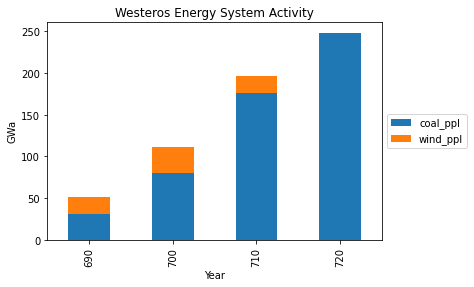

In [360]:
p.plot_activity(baseyear=True, subset=['coal_ppl', 'wind_ppl'])

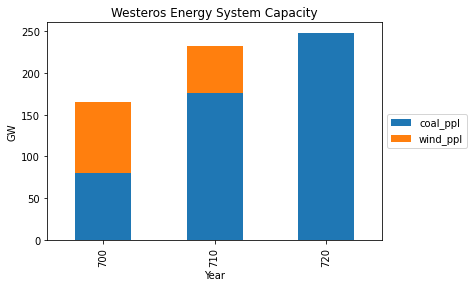

In [361]:
p.plot_capacity(baseyear=True, subset=['coal_ppl', 'wind_ppl'])

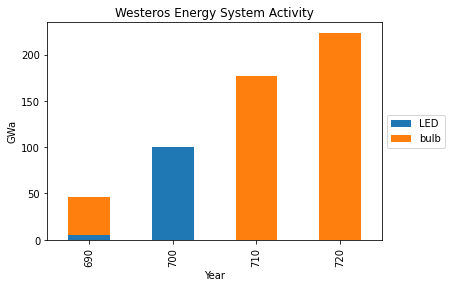

In [362]:
p.plot_activity(baseyear=True, subset=['bulb', 'LED'])

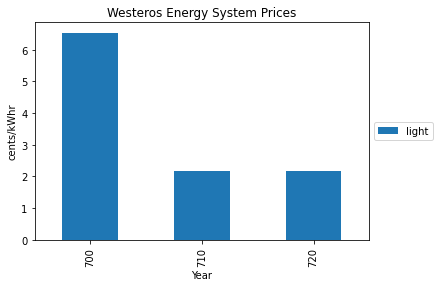

In [363]:
p.plot_prices(subset=['light'], baseyear=True)

Without taxation LED will not take over bulbs in the long term. But nonetheless this still affect the energy production, although not significantly. First of all the resulst from the objective function is slightly different being slightly higher when the diffusion rate is set to 0.01. Secondly When the diffusion rate is very low, the installed capacity in the decade 710 is also slightly higher, but this difference is supplied with wind power rather than coal. <br>
It is possible to change manually the diffusion rate, but for the sake of simplicity the two graphs are compared below:
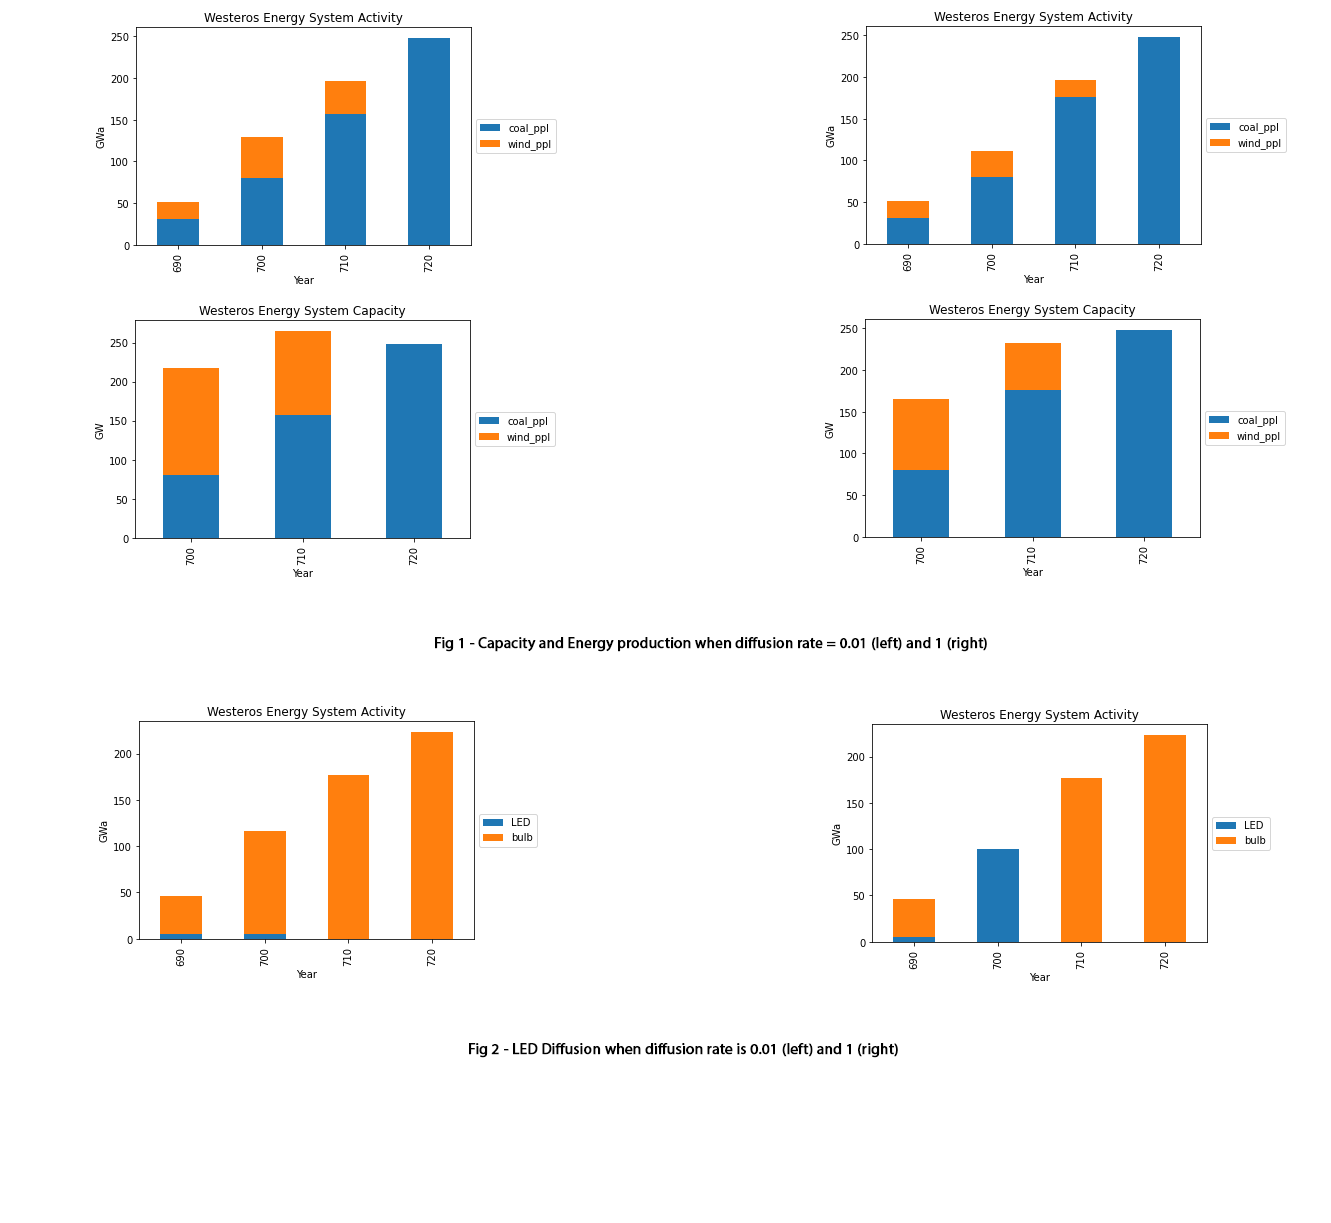

Now to understand why this happens it is needed to take a look at what actually happens to the LED penetration in the market. This is shown in the following figure.

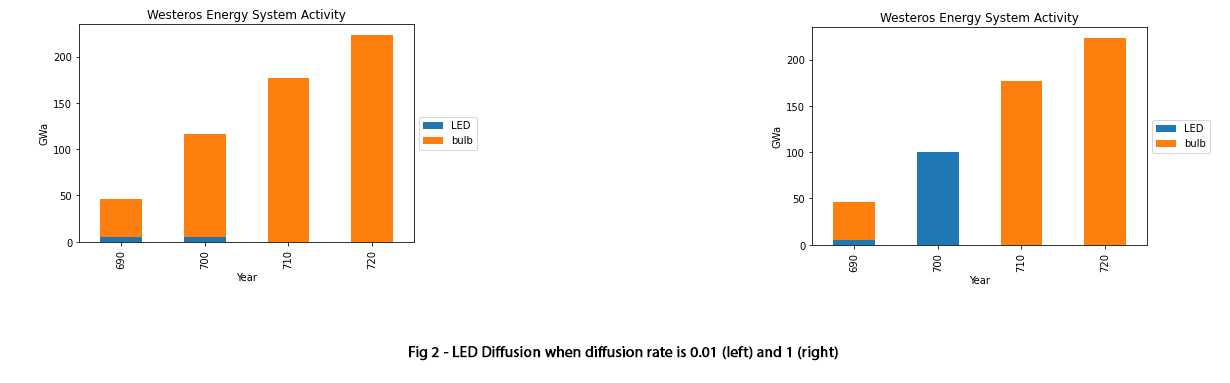

It can be noticed that when the diffusion rate is set to 0.01 LED never get used if not for the initial boundary condition at the year 690 that was set manually to be 10%. When the diffusion rate is set instead to 1 at least for the first decade (700 AC) shows a 100% diffusion of LED. But why would in the low diffusion rate LEDs even survive a little bit in the 710? And why do they die completely out in both diffusion cases? The answers to these questions lie in the following picture: 
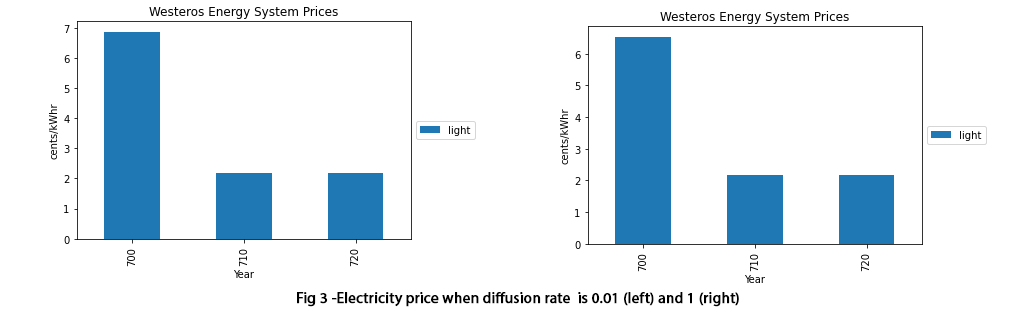

As it can be see in the first decade the electricity price is quite high compared to the following years. Therefore, people are more inclined to buy energy efficient LED rather than bulbs. During the following years the electricity price plummets, making the extra investment in LED quite worthless. Comparetively, when we keep the electricity price artificially high (i.e. by introducing carbon taxes), LED keep being more convenient than bulbs. 

In [364]:
mp.close_db()